In [1]:
import torch
import numpy as np
from sbi.inference import prepare_for_sbi, SNLE, SNPE
from sbi.simulators.linear_gaussian import diagonal_linear_gaussian
import sbi.utils as sbi_utils

pyknos/nflows/nn/nde


### Load theta and x

In [98]:
data = np.load('../results/cleaned_up_data_onlyNumSpikes_calibrationKernel.npz', allow_pickle=True)

x = torch.as_tensor(data['data'], dtype=torch.float32)
theta = torch.as_tensor(data['params'], dtype=torch.float32)

In [99]:
x = x[:, :1]

In [100]:
import sys
sys.path.append('../')

In [101]:
from parameter_setup import load_ground_truth_params, load_prior_min, load_prior_max

### Load data to standardize - needed to standardize x_o

In [102]:
mins, _ = torch.min(theta, dim=0)
print(mins)

tensor([ 2.0000e+01,  5.0000e-04,  2.0000e+01,  5.0005e-04,  2.0003e+01,
         5.0008e-04,  1.6614e-09,  3.9134e-09,  3.9221e-09,  4.3379e-07,
         1.4348e-08,  1.1566e-09,  2.3685e-09,  1.9186e-06,  3.6745e-07,
         9.5074e-08,  4.2545e-07,  4.8658e-08,  8.0016e-06,  8.9615e-07,
         4.4210e-09,  1.3498e-08,  6.3917e-09,  2.1546e-07,  8.4218e-07,
         8.4828e-09,  8.8416e-07, -3.0000e+00,  6.2148e-06,  1.5527e-06,
         3.0000e-05,  2.0000e-05,  3.0000e-05,  2.0000e-05,  3.3300e-01])


In [103]:
maxs, _ = torch.max(theta, dim=0)
print(maxs)

tensor([ 2.0000e+02,  5.0000e-02,  9.9999e+02,  5.0000e-02,  1.0000e+03,
         5.0000e-02,  5.0000e-03,  1.0000e-03,  1.0000e-03,  2.0000e-01,
         1.0000e-02,  1.0000e-02,  1.0000e-03,  1.0000e+00,  1.0000e+00,
         1.0000e-01,  1.0000e-01,  4.0000e-02,  4.0000e+00,  4.0000e+00,
         1.0000e-02,  1.0000e-02,  1.0000e-02,  1.0000e-01,  1.0000e-01,
         4.0000e-02,  1.0000e+00, -6.3502e-06,  2.0000e+00,  2.0000e+00,
         1.0000e-04,  5.0000e-05,  1.0000e-04,  5.0200e-05,  2.1360e+00])


In [104]:
print(gt_params)

[137.862136034238, 0.0005793520824526776, 199.1298048149789, 0.0006108049075983062, 152.1647419393015, 0.00742430653684668, 0.0010965218089651857, 0.0008186770602065786, 0.00011435310571497434, 0.0022763084379226854, 0.0036986082079423594, 0.00013883334761566004, 3.2474860530531394e-06, 0.005426837416265438, 0.10568666421909532, 0.04812676692103998, 0.094826660872338, 0.013854989311151315, 3.9010342040060975, 3.8851157748263354, 0.009964343408409574, 0.006000497448875096, 0.0012602755616811401, 0.01392240648099882, 0.06283710421562513, 6.68382138396179e-05, 0.08311048073340864, -2.9836949894223825, 1.9642986130169147, 1.2999358521956366, 4.4931548434199036e-05, 2.062212836678345e-05, 4.22059843297412e-05, 2.2409802171891654e-05, 1.7109080877160283]


In [105]:
x_mean = x.mean(dim=0)
x_std = x.std(dim=0)

dummy_prior = sbi_utils.BoxUniform(torch.as_tensor(load_prior_min()), torch.as_tensor(load_prior_max()))

theta_mean = dummy_prior.mean
theta_std = dummy_prior.stddev

In [106]:
x = (x-x_mean) / x_std
theta = (theta-theta_mean) / theta_std

In [107]:
theta.std(dim=0)

tensor([0.9998, 0.9963, 1.0001, 0.9991, 0.9998, 1.0005, 0.9983, 0.9996, 1.0006,
        1.0000, 1.0001, 0.9990, 0.9994, 1.0007, 1.0005, 0.9999, 1.0009, 0.9995,
        0.9986, 0.9938, 0.9996, 1.0000, 0.9867, 1.0003, 0.9993, 0.9981, 0.9987,
        1.0000, 0.9994, 1.0000, 1.0016, 1.0005, 0.9975, 1.0004, 0.4107])

In [108]:
theta.mean(dim=0)

tensor([-1.1898e-03,  3.6140e-03,  2.7931e-03,  1.1618e-03,  3.5554e-03,
        -1.0028e-03, -1.2959e-02,  1.9829e-04, -1.5160e-03, -7.8632e-03,
        -2.8268e-04,  6.7013e-04,  8.2654e-03, -2.0113e-04, -2.6095e-03,
        -1.8016e-04, -5.2981e-04,  6.5056e-04,  6.1090e-02,  8.0720e-02,
         1.8828e-02,  3.1534e-02,  1.5257e-02, -1.7815e-04, -3.3287e-03,
         2.8998e-03,  3.8502e-03,  1.2857e-03, -1.5259e-02, -3.0014e-02,
        -1.1918e-01, -8.5278e-04, -8.6408e-02, -4.8508e-03, -1.0605e+00])

In [109]:
maxs, _ = torch.max(theta, dim=0)
print(maxs)

tensor([1.7320, 1.7320, 1.7320, 1.7320, 1.7321, 1.7320, 1.7320, 1.7320, 1.7320,
        1.7320, 1.7321, 1.7320, 1.7320, 1.7320, 1.7320, 1.7320, 1.7320, 1.7321,
        1.7320, 1.7320, 1.7320, 1.7321, 1.7321, 1.7320, 1.7320, 1.7320, 1.7320,
        1.7320, 1.7320, 1.7321, 1.7320, 1.7320, 1.7320, 1.7320, 0.6098])


### Create dummy simulator and dummy prior

In [11]:
def dummy_simulator(theta):
    return torch.ones(1,1)

dummy_prior = sbi_utils.BoxUniform(torch.as_tensor(load_prior_min()), torch.as_tensor(load_prior_max()))
_bound = torch.sqrt(torch.as_tensor(3.))
dummy_prior_norm = sbi_utils.BoxUniform(-_bound*torch.ones(35), _bound*torch.ones(35))

In [12]:
from sbi.utils.get_nn_models import likelihood_nn, posterior_nn

In [14]:
simulator, prior, x_shape = prepare_for_sbi(dummy_simulator, dummy_prior_norm)

nsf_posterior = posterior_nn(
    model='nsf',
    prior=prior,
    x_o_shape=x_shape,
    hidden_features=100,
    flow_num_transforms=10,
)

In [16]:
inference = SNPE(
    simulator, 
    prior,
    x_shape,
    external_data=(theta, x), # todo: remove the [:1000] to train on all datasamples
    mcmc_method='slice', 
    density_estimator=nsf_posterior
)

In [18]:
posterior = inference(
    num_rounds=1,
    num_simulations_per_round=0,
    batch_size=100, # default is 50
    stop_after_epochs=5, # default is 20
)

Neural network successfully converged after 17 epochs.


In [19]:
import pickle
with open('../results/posteriors/200630_PosteriorSNPE_onlyBurst.pickle', 'wb') as handle:
    pickle.dump(posterior, handle)

# Temper the posterior

In [132]:
import numpy as np
x_o = torch.as_tensor(np.load('../results/observation/x_o_new_ss.npz')['x_o'], dtype=torch.float32)
x_o = x_o[:1]
x_o[0] = 2.

In [133]:
x_o = (x_o - x_mean) / x_std
x_o = x_o.unsqueeze(0)

In [134]:
x_o

tensor([[2.2962]])

### Analyse posterior

In [135]:
import pickle
with open('../results/posteriors/200630_PosteriorSNPE_onlyBurst.pickle', 'rb') as handle:
    posterior = pickle.load(handle)

In [136]:
s = []
num_iter = 5
num_samples_per_iter = 1000

for k in range(num_iter):
    print("new iter,", k)
    samples = posterior.sample((num_samples_per_iter,), x=x_o).detach()

    # denormalize the samples
    samples = samples * theta_std + theta_mean

    # convert to list for pickling
    samples_list = samples.numpy().tolist()
    
    s.append(samples_list)
s = np.asarray(s)
s = s.reshape(num_iter*num_samples_per_iter, -1)

new iter, 0
new iter, 1
new iter, 2
new iter, 3
new iter, 4


In [137]:
s_list = s.tolist()

In [150]:
print(s_list[0])

[181.93304443359375, 0.04783301800489426, 207.71337890625, 0.03203444182872772, 905.8734130859375, 0.015501477755606174, 1.969374716281891e-05, 0.00043420089059509337, 0.0005980271962471306, 0.043059419840574265, 0.005180958658456802, 0.004937729332596064, 0.0009761456167325377, 0.7163742780685425, 0.16538703441619873, 0.07783587276935577, 0.09268246591091156, 0.0004285573959350586, 0.6673499345779419, 3.7757821083068848, 0.005805934313684702, 0.00028786947950720787, 0.0050466000102460384, 0.06363409012556076, 0.030833164229989052, 0.006427803076803684, 0.8930135369300842, -0.4118105173110962, 0.08754241466522217, 0.34681421518325806, 8.008732402231544e-05, 4.058504055137746e-05, 6.472937093349174e-05, 3.6732686567120254e-05, 2.6999597549438477]


In [151]:
with open('../results/samples/200631_PosteriorSNPE_NumBurst_samples.pickle', 'wb') as handle:
    pickle.dump(s_list, handle, protocol=2)

In [140]:
gt_params = [137.862136034238,
 0.0005793520824526776,
 199.1298048149789,
 0.0006108049075983062,
 152.1647419393015,
 0.00742430653684668,
 0.0010965218089651857,
 0.0008186770602065786,
 0.00011435310571497434,
 0.0022763084379226854,
 0.0036986082079423594,
 0.00013883334761566004,
 3.2474860530531394e-06,
 0.005426837416265438,
 0.10568666421909532,
 0.04812676692103998,
 0.094826660872338,
 0.013854989311151315,
 3.9010342040060975,
 3.8851157748263354,
 0.009964343408409574,
 0.006000497448875096,
 0.0012602755616811401,
 0.01392240648099882,
 0.06283710421562513,
 6.68382138396179e-05,
 0.08311048073340864,
 -2.9836949894223825,
 1.9642986130169147,
 1.2999358521956366,
 4.4931548434199036e-05,
 2.062212836678345e-05,
 4.22059843297412e-05,
 2.2409802171891654e-05,
 1.7109080877160283]

In [141]:
gt_params_norm = (torch.as_tensor(gt_params) - theta_mean) / theta_std

In [142]:
theta_std

tensor([5.1962e+01, 1.4289e-02, 2.8290e+02, 1.4289e-02, 2.8290e+02, 1.4289e-02,
        1.4434e-03, 2.8868e-04, 2.8868e-04, 5.7735e-02, 2.8868e-03, 2.8868e-03,
        2.8868e-04, 2.8868e-01, 2.8868e-01, 2.8868e-02, 2.8868e-02, 1.1547e-02,
        1.1547e+00, 1.1547e+00, 2.8868e-03, 2.8868e-03, 2.8868e-03, 2.8868e-02,
        2.8868e-02, 1.1547e-02, 2.8868e-01, 8.6603e-01, 5.7735e-01, 5.7735e-01,
        2.0207e-05, 8.6603e-06, 2.0207e-05, 8.7180e-06, 7.6990e-01])

In [143]:
gt_params_norm

tensor([ 0.5362, -1.7265, -1.0989, -1.7243, -1.2649, -1.2475, -0.9724,  1.1039,
        -1.3359, -1.6926, -0.4508, -1.6840, -1.7208, -1.7133, -1.3659, -0.0649,
         1.5528, -0.5322,  1.6463,  1.6326,  1.7197,  0.3466, -1.2955, -1.2498,
         0.4447, -1.7263, -1.4441, -1.7132,  1.6702,  0.5195, -0.9931, -1.6602,
        -1.1280, -1.4556,  0.0577])

In [144]:
samples = posterior.sample((2000,), x=x_o).detach()

In [145]:
probs = posterior.log_prob(samples, x=x_o).detach().numpy()
prob_of_gt = posterior.log_prob(gt_params_norm.unsqueeze(0), x=x_o).detach().numpy()

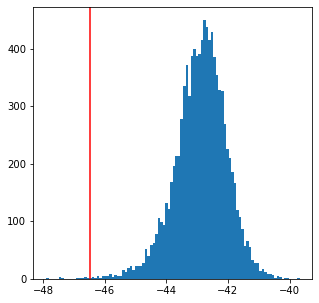

In [146]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(5,5))
_ = plt.hist(probs, bins=100)
ax.axvline(prob_of_gt, color='r')

In [147]:
prob_of_gt

array([-46.47035], dtype=float32)

In [148]:
dummy_prior_norm.log_prob(gt_params_norm.unsqueeze(0))

tensor([-43.4859])

### Posterior predictives
Has to be done in a different virtual env with python 2.